In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install timm torch torchvision --quiet

In [4]:
!pip install onnx ml_dtypes --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 111.8 MB/s eta 0:00:00


In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [6]:
data_dir = "/content/drive/MyDrive/work/Indian_bovine_breeds"

In [7]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [8]:
full_dataset = datasets.ImageFolder(data_dir, transform=train_transforms)
num_classes = len(full_dataset.classes)
print("Classes:", full_dataset.classes)

Classes: ['Brown_Swiss', 'Gir', 'Hariana', 'Holstein_Friesian', 'Jaffrabadi', 'Jersey', 'Kankrej', 'Mehsana', 'Murrah', 'Nili_Ravi', 'Ongole', 'Rathi', 'Red_Sindhi', 'Sahiwal', 'Surti', 'Tharparkar']


In [9]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

print(f"Number of images in training set: {len(train_dataset)}")
print(f"Number of images in validation set: {len(val_dataset)}")
print(f"Number of images in test set: {len(test_dataset)}")

Number of images in training set: 2175
Number of images in validation set: 621
Number of images in test set: 312


In [10]:
def evaluate_model(model, test_loader, criterion, name):
    model.eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"{name} [Test]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    test_acc = 100.*correct/total
    print(f"[{name}] Test Acc: {test_acc:.2f}% | Test Loss: {test_loss/len(test_loader):.4f}")
    return test_acc

# Example usage (assuming 'best_model' and 'model' from previous steps are available)
# evaluate_model(model, test_loader, criterion, best_model)

In [11]:
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform   = val_transforms

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=2)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
def train_model_with_history(model, optimizer, criterion, epochs=15, name="model", patience=5):
    history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}
    best_acc = 0
    epochs_no_improve = 0

    for epoch in range(epochs):
        # ---------- Training ----------
        model.train()
        train_loss, correct, total = 0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"{name} Epoch {epoch+1}/{epochs} [Train]"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
        train_acc = 100.*correct/total

        # ---------- Validation ----------
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"{name} Epoch {epoch+1}/{epochs} [Val]"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = outputs.max(1)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)
        val_acc = 100.*correct/total

        # ---------- Save history ----------
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_loss"].append(train_loss/len(train_loader))
        history["val_loss"].append(val_loss/len(val_loader))

        print(f"[{name}] Epoch {epoch+1}/{epochs} | "
              f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | "
              f"Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")

        # ---------- Check improvement and early stopping ----------
        if val_acc > best_acc:
            best_acc = val_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), f"/content/drive/MyDrive/work/cattle_breed/best_{name}.pth")
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"[{name}] Early stopping after {patience} epochs without improvement.")
                break

    return history, best_acc

In [15]:
def plot_history(history, name):
    epochs_range = range(1, len(history["train_acc"]) + 1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, history["train_acc"], label="Train Acc")
    plt.plot(epochs_range, history["val_acc"], label="Val Acc")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy (%)"); plt.title(f"{name} Accuracy"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, history["train_loss"], label="Train Loss")
    plt.plot(epochs_range, history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.title(f"{name} Loss"); plt.legend()
    plt.show()

In [16]:
results = {}
histories = {}
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/791M [00:00<?, ?B/s]

convnext_large Epoch 1/20 [Train]:  26%|██▋       | 18/68 [01:26<03:19,  3.98s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
convnext_large Epoch 1/20 [Val]: 100%|██████████| 20/20 [01:28<00:00,  4.42s/it]


[convnext_large] Epoch 1/20 | Train Acc: 19.49% | Val Acc: 31.40% | Train Loss: 2.5999 | Val Loss: 2.2899


convnext_large Epoch 2/20 [Train]:  65%|██████▍   | 44/68 [01:56<01:02,  2.61s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
convnext_large Epoch 2/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


[convnext_large] Epoch 2/20 | Train Acc: 40.87% | Val Acc: 45.09% | Train Loss: 2.0367 | Val Loss: 1.8695


convnext_large Epoch 3/20 [Train]:   1%|▏         | 1/68 [00:04<05:06,  4.58s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
convnext_large Epoch 3/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


[convnext_large] Epoch 3/20 | Train Acc: 54.85% | Val Acc: 56.20% | Train Loss: 1.5909 | Val Loss: 1.4833


convnext_large Epoch 4/20 [Train]:  37%|███▋      | 25/68 [01:30<01:54,  2.65s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
convnext_large Epoch 4/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


[convnext_large] Epoch 4/20 | Train Acc: 65.75% | Val Acc: 63.45% | Train Loss: 1.2400 | Val Loss: 1.2130


convnext_large Epoch 5/20 [Train]:  12%|█▏        | 8/68 [00:43<09:31,  9.53s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
convnext_large Epoch 5/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


[convnext_large] Epoch 5/20 | Train Acc: 73.93% | Val Acc: 69.57% | Train Loss: 0.9966 | Val Loss: 1.0434


convnext_large Epoch 6/20 [Train]:  15%|█▍        | 10/68 [00:49<04:47,  4.96s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
convnext_large Epoch 6/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


[convnext_large] Epoch 6/20 | Train Acc: 78.39% | Val Acc: 72.95% | Train Loss: 0.8230 | Val Loss: 0.9312


convnext_large Epoch 7/20 [Train]:  60%|██████    | 41/68 [02:09<01:09,  2.58s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
convnext_large Epoch 7/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


[convnext_large] Epoch 7/20 | Train Acc: 83.63% | Val Acc: 73.59% | Train Loss: 0.6936 | Val Loss: 0.8692


convnext_large Epoch 8/20 [Train]:  72%|███████▏  | 49/68 [02:32<00:49,  2.62s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
convnext_large Epoch 8/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


[convnext_large] Epoch 8/20 | Train Acc: 87.26% | Val Acc: 75.85% | Train Loss: 0.5902 | Val Loss: 0.8063


convnext_large Epoch 9/20 [Train]:  53%|█████▎    | 36/68 [01:59<01:22,  2.58s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
convnext_large Epoch 9/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


[convnext_large] Epoch 9/20 | Train Acc: 90.39% | Val Acc: 76.01% | Train Loss: 0.5034 | Val Loss: 0.7679


convnext_large Epoch 10/20 [Train]:  51%|█████▏    | 35/68 [01:53<01:25,  2.58s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
convnext_large Epoch 10/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


[convnext_large] Epoch 10/20 | Train Acc: 92.14% | Val Acc: 77.46% | Train Loss: 0.4295 | Val Loss: 0.7488


convnext_large Epoch 11/20 [Train]:  63%|██████▎   | 43/68 [02:14<01:04,  2.59s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
convnext_large Epoch 11/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


[convnext_large] Epoch 11/20 | Train Acc: 94.21% | Val Acc: 77.78% | Train Loss: 0.3671 | Val Loss: 0.7241


convnext_large Epoch 12/20 [Train]:  41%|████      | 28/68 [01:36<01:44,  2.61s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
convnext_large Epoch 12/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


[convnext_large] Epoch 12/20 | Train Acc: 95.45% | Val Acc: 78.10% | Train Loss: 0.3107 | Val Loss: 0.7057


convnext_large Epoch 13/20 [Train]:  62%|██████▏   | 42/68 [02:11<01:07,  2.58s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
convnext_large Epoch 13/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


[convnext_large] Epoch 13/20 | Train Acc: 96.18% | Val Acc: 78.58% | Train Loss: 0.2651 | Val Loss: 0.7003


convnext_large Epoch 14/20 [Train]:  75%|███████▌  | 51/68 [02:37<00:44,  2.62s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
convnext_large Epoch 14/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


[convnext_large] Epoch 14/20 | Train Acc: 96.97% | Val Acc: 79.39% | Train Loss: 0.2255 | Val Loss: 0.6911


convnext_large Epoch 15/20 [Train]:  56%|█████▌    | 38/68 [02:01<01:17,  2.58s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
convnext_large Epoch 15/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


[convnext_large] Epoch 15/20 | Train Acc: 97.20% | Val Acc: 77.94% | Train Loss: 0.1916 | Val Loss: 0.6852


convnext_large Epoch 16/20 [Train]:   9%|▉         | 6/68 [00:16<02:45,  2.68s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
convnext_large Epoch 16/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


[convnext_large] Epoch 16/20 | Train Acc: 97.70% | Val Acc: 77.62% | Train Loss: 0.1620 | Val Loss: 0.6832


convnext_large Epoch 17/20 [Train]:  35%|███▌      | 24/68 [01:05<01:54,  2.61s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
convnext_large Epoch 17/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


[convnext_large] Epoch 17/20 | Train Acc: 98.25% | Val Acc: 78.42% | Train Loss: 0.1385 | Val Loss: 0.6832


convnext_large Epoch 18/20 [Train]:  25%|██▌       | 17/68 [00:45<02:13,  2.62s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
convnext_large Epoch 18/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


[convnext_large] Epoch 18/20 | Train Acc: 98.34% | Val Acc: 78.58% | Train Loss: 0.1195 | Val Loss: 0.6808


convnext_large Epoch 19/20 [Train]:  44%|████▍     | 30/68 [01:19<01:38,  2.60s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
convnext_large Epoch 19/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


[convnext_large] Epoch 19/20 | Train Acc: 98.53% | Val Acc: 77.78% | Train Loss: 0.1027 | Val Loss: 0.6940


convnext_large Epoch 20/20 [Train]:  43%|████▎     | 29/68 [01:16<01:41,  2.61s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
convnext_large Epoch 20/20 [Val]: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


[convnext_large] Epoch 20/20 | Train Acc: 98.57% | Val Acc: 78.10% | Train Loss: 0.0916 | Val Loss: 0.6898


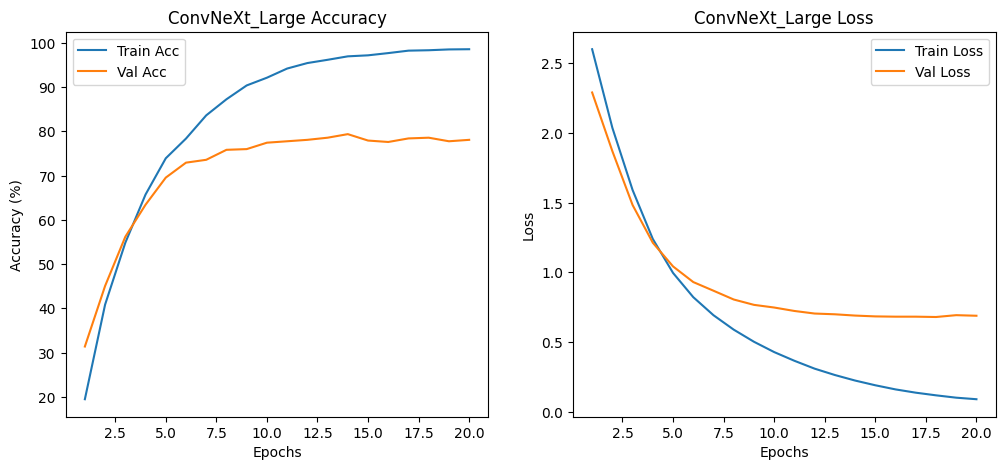

In [17]:
# ConvNeXt Large with Advanced Settings
convnext_large = timm.create_model("convnext_large", pretrained=True, num_classes=num_classes).to(device)

# Advanced optimizer with learning rate scheduler
optimizer_large = optim.AdamW(convnext_large.parameters(), lr=2e-5, weight_decay=0.05)
scheduler_large = optim.lr_scheduler.OneCycleLR(
    optimizer_large,
    max_lr=1e-4,
    epochs=20,
    steps_per_epoch=len(train_loader),
    pct_start=0.2
)

history_large, acc_large = train_model_with_history(
    convnext_large,
    optimizer_large,
    criterion,
    epochs=20,
    name="convnext_large",
    patience=7 # Added patience parameter
)

plot_history(history_large, "ConvNeXt_Large")
results["ConvNeXt_Large"] = acc_large
histories["ConvNeXt_Large"] = history_large

In [18]:
print("\n==== Final Validation Accuracies ====")
for model_name, acc in results.items():
    print(f"{model_name}: {acc:.2f}%")

best_model = max(results, key=results.get)
print(f"\n✅ Best Model: {best_model} with {results[best_model]:.2f}% validation accuracy")


==== Final Validation Accuracies ====
ConvNeXt_Large: 79.39%

✅ Best Model: ConvNeXt_Large with 79.39% validation accuracy


In [19]:

def compare_models(histories, metric="acc"):
    plt.figure(figsize=(12,6))

    for name, history in histories.items():
        if metric == "acc":
            plt.plot(history["train_acc"], label=f"{name} Train")
            plt.plot(history["val_acc"], linestyle="--", label=f"{name} Val")
            plt.ylabel("Accuracy (%)")
            plt.title("Train vs Val Accuracy Comparison")
        elif metric == "loss":
            plt.plot(history["train_loss"], label=f"{name} Train")
            plt.plot(history["val_loss"], linestyle="--", label=f"{name} Val")
            plt.ylabel("Loss")
            plt.title("Train vs Val Loss Comparison")

    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

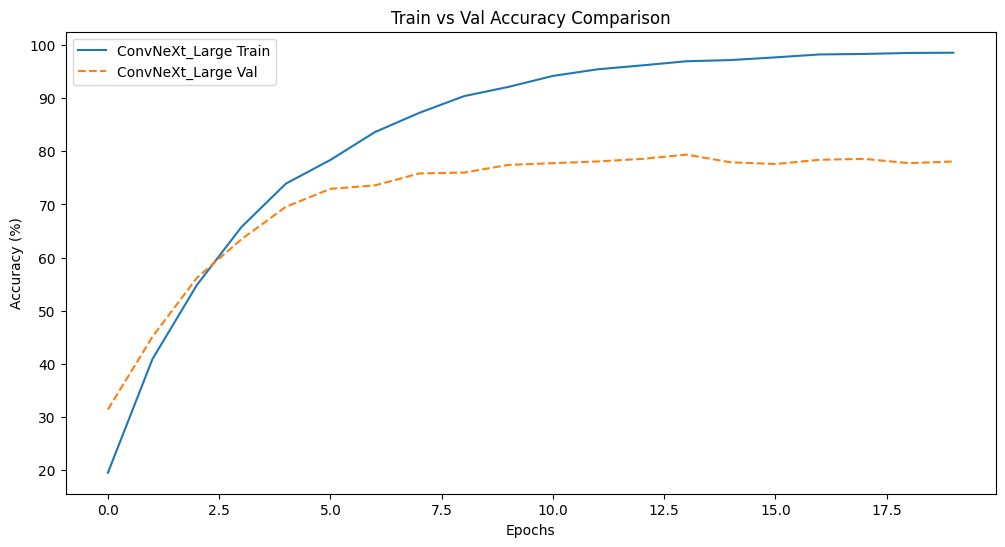

In [20]:
# Accuracy comparison
compare_models(histories, metric="acc")

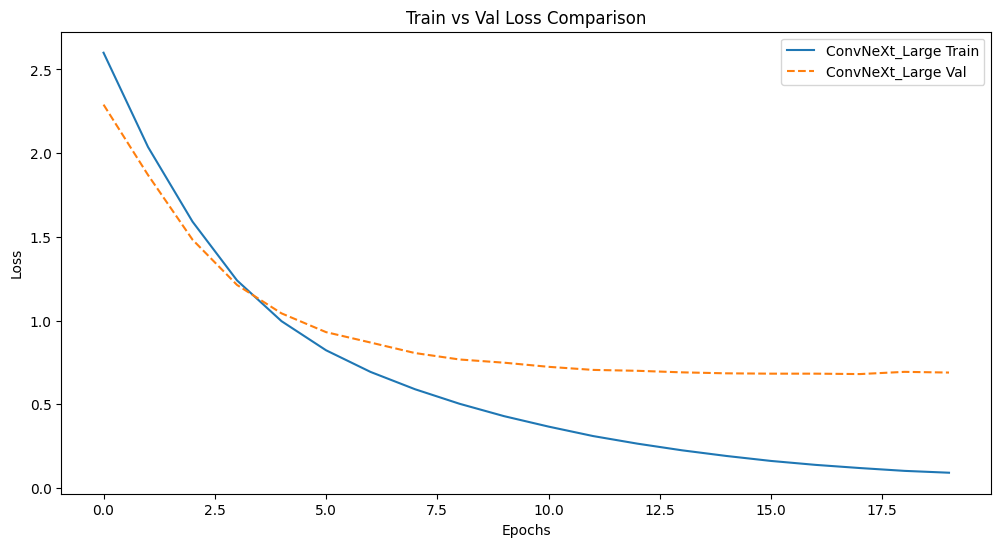

In [21]:
# Loss comparison
compare_models(histories, metric="loss")

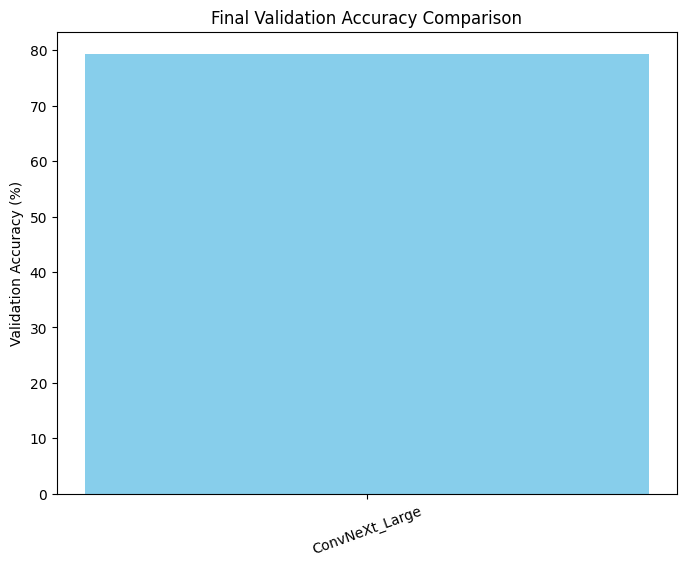

In [22]:
plt.figure(figsize=(8,6))
plt.bar(results.keys(), results.values(), color=["skyblue","lightgreen","salmon","orange"])
plt.ylabel("Validation Accuracy (%)")
plt.title("Final Validation Accuracy Comparison")
plt.xticks(rotation=20)
plt.show()

# =============================
# STEP 8: Inference with Unknown Detection
# =============================

In [23]:
def predict_image(image_path, model, class_names, threshold=0.7):
    """
    Predicts the class of an image, or flags as unknown if confidence < threshold.
    """
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        max_prob, pred_class = torch.max(probs, 1)

    max_prob = max_prob.item()
    pred_class = pred_class.item()

    if max_prob < threshold:
        return "⚠️ Unknown Image — Not a recognized cattle/buffalo breed"
    else:
        return f"✅ Predicted: {class_names[pred_class]} (Confidence: {max_prob:.2f})"

# Load the best model (update with correct model name if needed)

In [24]:
model = timm.create_model(best_model.lower(), pretrained=False, num_classes=num_classes).to(device)
model.load_state_dict(torch.load(f"/content/drive/MyDrive/work/cattle_breed/best_{best_model.lower()}.pth"))
model.eval()

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (norm): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_features=768, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=768, out_features=192, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), g

# Predict on a new image

In [25]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  # Use the first uploaded file for prediction
  test_img = fn

Saving Jersey_3.jpg to Jersey_3.jpg
User uploaded file "Jersey_3.jpg" with length 8637 bytes


In [26]:
result = predict_image(test_img, model, full_dataset.classes, threshold=0.7)
print(result)

✅ Predicted: Jersey (Confidence: 0.96)


In [27]:
import json

# Export Best Model for Deployment

In [28]:
best_model_name = best_model  # update if best was different
weights_path = f"/content/drive/MyDrive/work/cattle_breed/best_{best_model_name.lower()}.pth"

In [29]:
example_input = torch.randn(1, 3, 224, 224).to(device)
traced_model = torch.jit.trace(model, example_input)
torchscript_path = f"/content/drive/MyDrive/work/cattle_breed/best_{best_model_name.lower()}_scripted.pt"
traced_model.save(torchscript_path)

In [31]:
model = timm.create_model(best_model_name.lower(), pretrained=False, num_classes=num_classes).to(device)
model.load_state_dict(torch.load(weights_path))
model.eval()

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (norm): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_features=768, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=768, out_features=192, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), g

In [32]:
print(f"TorchScript model saved to: {torchscript_path}")

TorchScript model saved to: /content/drive/MyDrive/work/cattle_breed/best_convnext_large_scripted.pt


In [33]:
metadata = {
    "model_name": "swin_small_patch4_window7_224",
    "num_classes": num_classes,
    "class_labels": full_dataset.classes,
    "input_size": [3, 224, 224],
    "normalization": {
        "mean": [0.485, 0.456, 0.406],
        "std": [0.229, 0.224, 0.225]
    }
}

In [34]:
json_path = f"/content/drive/MyDrive/work/cattle_breed/{best_model_name}_metadata.json"
with open(json_path, "w") as f:
    json.dump(metadata, f, indent=4)

In [35]:
print(f"Metadata JSON saved to: {json_path}")

Metadata JSON saved to: /content/drive/MyDrive/work/cattle_breed/ConvNeXt_Large_metadata.json


In [36]:
onnx_path = f"/content/drive/MyDrive/work/cattle_breed/{best_model_name}.onnx"
torch.onnx.export(
    model,
    example_input,
    onnx_path,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch"}, "output": {0: "batch"}},
    opset_version=13
)
print(f"ONNX model saved to: {onnx_path}")

/tmp/ipython-input-3351260576.py:2: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


ONNX model saved to: /content/drive/MyDrive/work/cattle_breed/ConvNeXt_Large.onnx


Now that the model is loaded correctly, you can proceed with testing it on a new image and exporting it for deployment.